# Investigation of torchbnn module

## Source:
### This code is written with the help of following notebook. 
#### Title: Bayesian-Neural-Network-Pytorch
#### Link: https://github.com/Harry24k/bayesian-neural-network-pytorch

In [1]:
! pip install torchbnn

In [2]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Considerations

In [3]:
hidden1=500 
hidden2=500
training_iteration = 10000

# Data

In [4]:
train_csv_path = '../input/toy-dataset-for-regression-and-uq/Data3_Train.csv'
test_csv_path = '../input/toy-dataset-for-regression-and-uq/Data3_Test.csv'
val_csv_path = '../input/toy-dataset-for-regression-and-uq/Data3_Val.csv'

train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
train_df.head()

,Input1,Input2,Input3,Output
0,2.659116,4.673695,1.231898,-1.010633
1,6.172297,0.308095,6.197296,0.140169
2,1.620350,3.752477,3.010036,0.014108
3,6.269573,3.173038,6.019555,-0.016590
4,3.946378,3.264015,2.245954,1.222183


In [5]:
input_=[]
output_=[]
for row in train_df.iloc:
    input_.append((row[0:len(row)-1]).astype(float))
    output_.append(row[-1])
    
i_val=[]
o_val=[]
for row in val_df.iloc:
    i_val.append((row[0:len(row)-1]).astype(float))
    o_val.append(row[-1])
    
num_input = len(row)-1;
print(num_input)




x = torch.tensor(input_).float()  
y = torch.tensor(output_).float()   
new_shape = (len(y), 1)
y = y.view(new_shape)


i_val = torch.tensor(i_val).float()  
o_val = torch.tensor(o_val).float()   
new_shape = (len(o_val), 1)
o_val = o_val.view(new_shape)



max_y = torch.max(y[:,0])
min_y =torch.min(y[:,0])

max_x = torch.max(x,dim=0)
min_x = torch.min(x,dim=0)

print(max_y, min_y, max_x.values, min_x.values)

range_y = max_y - min_y
range_x = max_x.values - min_x.values

print(range_x, range_y)

    #Normalizing
x = (x - min_x.values)/range_x
y = (y - min_y)/range_y

    #Normalizing
i_val = (i_val - min_x.values)/range_x
o_val = (o_val - min_y)/range_y

3
tensor(1.4626) tensor(-1.4431) tensor([6.2822, 6.2817, 6.2823]) tensor([4.0563e-04, 6.2234e-05, 9.0123e-04])
tensor([6.2818, 6.2816, 6.2814]) tensor(2.9057)


# Model

In [6]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=num_input, out_features=hidden1),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden1, out_features=hidden2),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden2, out_features=1),
)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train

In [7]:
kl_weight = 0.1
since = time.time()

print("Training Iteration:",training_iteration)

for step in range(training_iteration):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if step%500==100:   
        print(step/training_iteration*100, '%' '  Complete')
        time_elapsed = time.time() - since

time_elapsed = time.time() - since
print('100% Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  
        
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

Training Iteration: 10000
1.0 %  Complete
6.0 %  Complete
11.0 %  Complete
16.0 %  Complete
21.0 %  Complete
26.0 %  Complete
31.0 %  Complete
36.0 %  Complete
41.0 %  Complete
46.0 %  Complete
51.0 %  Complete
56.00000000000001 %  Complete
61.0 %  Complete
66.0 %  Complete
71.0 %  Complete
76.0 %  Complete
81.0 %  Complete
86.0 %  Complete
91.0 %  Complete
96.0 %  Complete
100% Complete in 14m 56s
- MSE : 0.00, KL : 0.03


# Test

In [8]:
x_test = i_val
y_test = o_val

y_test = torch.unsqueeze(y_test, dim=1)

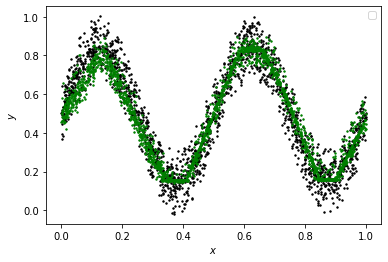

In [9]:
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.scatter(x_test[:,0].data.numpy(), y_test.data.numpy(), color='k', s=2) 

for iter in range(1):
    y_predict = model(x_test)
    plt.scatter(x_test[:,0].data.numpy(), y_predict.data.numpy(), color='g', s=2)

plt.legend()
plt.show()

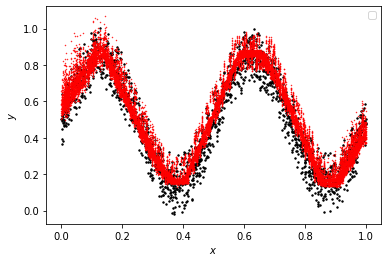

In [10]:
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.scatter(x_test[:,0].data.numpy(), y_test.data.numpy(), color='k', s=2) 

for iter in range(10):
    y_predict = model(x_test)
    plt.scatter(x_test[:,0].data.numpy(), y_predict.data.numpy(), color='r', s=0.2)

plt.legend()
plt.show()